In [ ]:
AtivaStopWords = 0
AtivaSteming = 0
EPC = 50
FuncaoAtivacao = 'sigmoid'
Otimizador = 'Adam'

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
nltk.download('rslp')
nltk.download('stopwords')
from nltk.stem import RSLPStemmer #Removedor de Sufixos da Língua Portuguesa

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras import backend as K
nltk.download('punkt')
import time

startTotalTime = time.time()


#opinion_reviews = pd.read_excel("/content/drive/MyDrive/Mestrado/RedeNeuralMestrado/AvalicoesAmazonFinal.xlsx")
#opinion_reviews = pd.read_excel("/content/drive/MyDrive/Mestrado/RedeNeuralMestrado/amazon_cells_labelled2colrminer.xlsx")
opinion_reviews = pd.read_excel("/content/drive/MyDrive/Mestrado/RedeNeuralMestrado/QuestionarioISP2.xlsx")


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
opinion_reviews.isnull().values.any()

False

In [ ]:
opinion_reviews.shape

(509, 2)

In [ ]:
opinion_reviews.head()

,Opinioes,Sentimento
0,Muito legal ver os produtos presencialmente,p
1,Muito boa,p
2,Gosto de comprar no isp porque o site é bastan...,p
3,Gosto de comprar no isp porque o site é bastan...,p
4,Competência,p


In [ ]:
opinion_reviews["Opinioes"][3]

'Gosto de comprar no isp porque o site é bastante prático e os consultores são sempre atenciosos.'

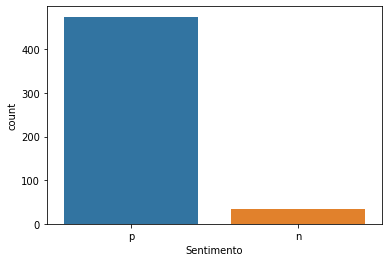

In [ ]:
import seaborn as sns

sns.countplot(x='Sentimento', data=opinion_reviews)

**Definição de parâmetros**

**Iniciando Pré-processamento**

In [ ]:
startPreProcTime = time.time()

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
#Retirar Stopwords
def RemoveStopWords(sentence):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    phrase = []
    sentence = sentence.lower()
    sentence = nltk.word_tokenize(sentence)
    for word in sentence:
        if word not in stopwords:
            phrase.append(word)
        
    return ' '.join(phrase)

In [ ]:
#Teste retirada de stopwords
if AtivaStopWords == 1:
  sentences = list(opinion_reviews['Opinioes'])
  resultado_stopwords = []
  for frase in sentences:
   resultado_stopwords.append(RemoveStopWords(frase))
  print(resultado_stopwords[2])

In [ ]:
#Stemming
def Stemming(sentence):
    stemmer = RSLPStemmer()
    phrase = []
    sentence = nltk.word_tokenize(sentence)
    for word in sentence:
        phrase.append(stemmer.stem(word.lower()))
    return ' '.join(phrase)

In [ ]:
#Teste Stemming
if AtivaSteming == 1:
  if AtivaStopWords == 1:
    sentences = list(resultado_stopwords)
  else:
    sentences = list(opinion_reviews['Opinioes'])
  resultado_stem = []
  for frase in sentences:
    resultado_stem.append(Stemming(frase))
  print(resultado_stem[1])

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
if AtivaStopWords == 1:
  sentences = list(resultado_stopwords)
elif AtivaSteming == 1:
  sentences = list(resultado_stem)
else: 
  sentences = list(opinion_reviews['Opinioes'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[3]

'Gosto de comprar no isp porque site bastante pr tico os consultores o sempre atenciosos '

In [ ]:
elapsed_time_pre = time.time() - startPreProcTime
print("Tempo de pre-processamento",elapsed_time_pre)

Tempo de pre-processamento 0.117706298828125


In [ ]:
y = opinion_reviews['Sentimento']

y = np.array(list(map(lambda x: 1 if x=="p" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, train_size= 0.70, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
import re

embeddings_dictionary = dict()
#glove_file = open('/content/drive/MyDrive/glove_s50.txt', encoding="utf8")
glove_file = open('/content/drive/MyDrive/glove.6B.50d.txt', encoding="utf8")
for i, line in enumerate(glove_file):
    try:
      line = line.strip()
      if line == "":
        continue
      line = line.replace(",",".")
      records = line.split()
      word = records[0]
      vector_dimensions = asarray(records[1:], dtype='float32')
      embeddings_dictionary [word] = vector_dimensions
    except:
      print (i)
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.layers.recurrent import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(50,activation='relu'))
model.add(Dense(1, activation=FuncaoAtivacao))
model.compile(optimizer=Otimizador, loss='binary_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            21600     
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 119,749
Trainable params: 98,149
Non-trainable params: 21,600
_________________________________________________________________
None


In [ ]:
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=128, epochs=EPC, verbose=1, validation_split=0.3)

score = model.evaluate(X_test, y_test, verbose=1)
elapsed_time = time.time() - start_time
print ("processing time:", elapsed_time, "seconds")

Epoch 1/50
2/2 [==============================] - 4s 736ms/step - loss: 0.6902 - acc: 0.6707 - f1_m: 0.7691 - precision_m: 0.9394 - recall_m: 0.7083 - val_loss: 0.6798 - val_acc: 0.9439 - val_f1_m: 0.9712 - val_precision_m: 0.9439 - val_recall_m: 1.0000
Epoch 2/50
2/2 [==============================] - 0s 233ms/step - loss: 0.6761 - acc: 0.9277 - f1_m: 0.9621 - precision_m: 0.9272 - recall_m: 1.0000 - val_loss: 0.6604 - val_acc: 0.9439 - val_f1_m: 0.9712 - val_precision_m: 0.9439 - val_recall_m: 1.0000
Epoch 3/50
2/2 [==============================] - 0s 243ms/step - loss: 0.6546 - acc: 0.9277 - f1_m: 0.9626 - precision_m: 0.9279 - recall_m: 1.0000 - val_loss: 0.6285 - val_acc: 0.9439 - val_f1_m: 0.9712 - val_precision_m: 0.9439 - val_recall_m: 1.0000
Epoch 4/50
2/2 [==============================] - 0s 241ms/step - loss: 0.6188 - acc: 0.9277 - f1_m: 0.9626 - precision_m: 0.9279 - recall_m: 1.0000 - val_loss: 0.5637 - val_acc: 0.9439 - val_f1_m: 0.9712 - val_precision_m: 0.9439 - val_r

In [ ]:
elapsedTotalTime = time.time() - startTotalTime

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2683148980140686
Test Accuracy: 0.9411764740943909


In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("Loss:", round(loss,8))
print("Accuracy:", round(accuracy,8))
print("Precision:", round(precision,8))
print("Recall", round(recall,8))
print("F1_Score:", round(f1_score,8))
print("Tempo de processamento da rede:", str(elapsed_time).replace(".", ","))
print("Tempo de pre-processamento:",str(elapsed_time_pre).replace(".", ","))
print("Tempo total:", str(elapsedTotalTime).replace(".", ","))


Loss: 0.2683149
Accuracy: 0.94117647
Precision: 0.96021497
Recall 0.97973889
F1_Score: 0.96969873
Tempo de processamento da rede: 44,44068956375122
Tempo de pre-processamento: 0,117706298828125
Tempo total: 51,935200452804565


In [ ]:
from tabulate import tabulate

table = [
         [str(loss).replace(".",",")],
         [str(accuracy).replace(".",",")],
         [str(precision).replace(".",",")],
         [str(recall).replace(".",",")],
         [str(f1_score).replace(".",",")],
         [str(elapsed_time).replace(".", ",")],
         [str(elapsed_time_pre).replace(".", ",")],
         [str(elapsedTotalTime).replace(".", ",")]
]

print(tabulate(table))

------------------
0,2683148980140686
0,9411764740943909
0,9602149724960327
0,9797388911247253
0,9696987271308899
44,44068956375122
0,117706298828125
51,935200452804565
------------------


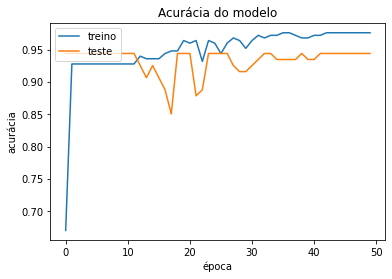

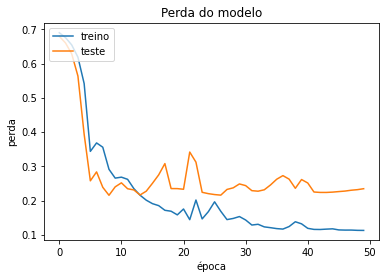

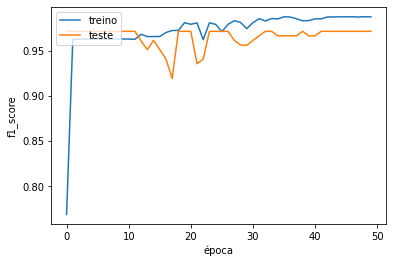

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Acurácia do modelo')
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino','teste'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


plt.title('Perda do modelo')
plt.ylabel('perda')
plt.xlabel('época')
plt.legend(['treino','teste'], loc='upper left')
plt.show()


plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])


#plt.title('f1_score do modelo')
plt.ylabel('f1_score')
plt.xlabel('época')
plt.legend(['treino','teste'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(y_test, np.round(model.predict(X_test)))


array([[  4,   6],
       [  3, 140]])

In [ ]:
confusion_matrix(y_train, np.round(model.predict(X_train)))

array([[ 12,  12],
       [  0, 332]])